# Réchauffement climatique et flux touristiques en France sur les années 2010
Manon Chevallier, Sara Chikhi, Inza Ouada Soro

# Table des matières
* [1. Import des données](#chapter1)
    * [1.1. Justification du champ](#section_1_1)
    * [1.2. Données climatiques](#section_1_2)
    * [1.3. Données touristiques](#section_1_3)
    * [1.4. Jointure](#section_1_4)
* [2. Statistiques descriptives](#chapter2)
    * [2.1. Statistiques sur le climat](#section_2_1)
        * [2.1.1. Variabilité climatique sur le territoire](#sub_section_2_1_1)
        * [2.1.2. Evolution dans le temps](#sub_section_2_1_2)
    * [2.2. Statistiques sur le tourisme](#section_2_1)
        * [2.2.1. Répartition du tourisme sur le territoire](#sub_section_2_2_1)
        * [2.2.2. Evolution des fréquentations touristiques](#sub_section_2_2_2)
    * [2.3. Corrélations](#section_2_1)
        * [2.3.1. Corrélation climat - nombre d'arrivées (tous touristes confondus)](#sub_section_2_3_1)
        * [2.3.1. Corrélation climat - nombre d'arrivées selon l'origine des touristes](#sub_section_2_3_2)
* [3. Modélisation](#chapter3)
    * [Présentation du modèle](#section_3_1)
    * [Résultats](#section_3_2)
* [4. Conclusion](#chapter4)


_Un certain nombre de programmes ne sont pas rédigés dans ce notebook mais seulement appelés par celui-ci. Ils sont lisibles dans le dossier src._

_Tous les packages nécessaires à nos programmes et leurs versions associées sont répertoriés dans_ requirements.txt.

## 1. Import des données <a class="anchor" id="chapter1"></a>

In [35]:
import time
t0 = time.perf_counter()

In [36]:
import os
from IPython.display import clear_output
print(os.getcwd())

/home/onyxia/work/Project


Nous utilisons des données climatiques issues de météo france et des données sur les fréquentations touristiques issues d'une enquête mensuelle auprès des établissements touristiques. Ces deux sources de données sont importées à partir d'internet. Les codes permettant d'importer ces données se trouvent dans le dossier src/import_data. 

In [37]:
# temps approximatif : 52s
from src import import_data
%run src/import_data/api_donnees_climat.py
%run src/import_data/api_donnees_tourisme.py

Fichier climat sauvegardé dans : /home/onyxia/work/Project/Data/data_climat.csv
Fichier tourisme sauvegardé dans : /home/onyxia/work/Project/Data/data_tourisme.csv
Fichier tourisme sauvegardé dans : /home/onyxia/work/Project/Data/data_tourisme2.csv


Ce dossier comporte deux scripts (api_donnees_climat et api_donnees_tourisme) qui chacun importent les données et les retraitent légèrement pour qu'elles soient cohérentes entre elles. En particulier, il faut qu'elles soient toutes deux au niveau départemental, annuel et mensuel. Chaque ligne de notre table de données correspondra donc à un département x une année x un mois. Nous produisons également une troisième base (data_tourisme2) comprenant l'origine des touristes, que nous traiterons plus tard.

### 1.1. Justification du champ <a id="section_1_1"></a>

#### Champ géographique
Nous nous concentrons sur les données métropolotaines et Corse, et excluons les départements et régions d'outre-mer. Deux raisons principales expliquent ce choix. D'abord, ce sont des régions au climat différent (tropical) de celui de la France métropolitaine (continental). La spécificité de ces régions aurait nécessité une analyse à part ce qui aurait complexifié les analyses. Par ailleurs, les voyages en outre-mer sont de nature différente de ceux sur le territoire métropolitain ou Corse, en particulier, ils sont beaucoup plus couteux financièrement. Nous faisons donc comme hypothèse que le choix de ces destinations est moins sensible à des considérations climatiques, s'organisant probablement de plus longue haleine que des voyages métropolitains. 

Nous avons opté pour la granularité géographique départementale. Il nous semblait en effet qu'elle était suffisamment précise pour distinguer les zones littorales et montagneuses des autres, contrairement à l'échelle régionale. Nous nous sommes assurés de la représentativité des résultats au niveau régional en contactant directement l'une des productrices de ces données travaillant à l'Insee (Jeanne Pages).

#### Champ temporel
La période temporelle retenue court de janvier 2011 à décembre 2019. La raison de ce choix se trouve en partie dans des contraintes techniques (les données touristiques n'étant disponible qu'à partir de 2011) mais elle nous a paru pertinente pour répondre à notre problématique, et ce pour trois raisons. D'abord, les décisions de destinations touristiques se font généralement au cours de l'année, en prenant en compte les quelques années précédentes, voire l'année précédente seulement. Ainsi, en adoptant une période de près de 10 ans, nous avons suffisamment d'observations différentes pour avoir des résultats. Ensuite, la décennie des années 2010 est intéressante car elle a vu s'intensifier les épisodes climatiques de façon assez nette : "Sur les 51 vagues de chaleur recensées depuis 1947 à l'échelle nationale : 25 ont eu lieu entre 1947 et 2010 ; 26 ont eu lieu depuis 2011." d'après Météo-France. Enfin, nous avons choisi de ne pas sélectionner les années ultérieures à 2019 en raison de la crise sanitaire qui a fortement perturbé les flux touristiques. 

### 1.2. Données climatiques <a id="section_1_2"></a>

On importe les données climatiques en ne sélectionnant que nos variables d'intérêt, c'est-à-dire celles permettant d'obtenir la température moyenne, les températures maximales et les évènements de forte chaleur ou de forte froideur (voir api_donnees_climat). On analyse les valeurs manquantes.


In [38]:
import pandas

data_1 = pandas.read_csv("./Data/data_climat.csv")
data_1["DEP"] = data_1["DEP"].astype(str).str.zfill(2)
colonnes_climat = data_1.columns.values[2:len(data_1.columns.values)]

for i in colonnes_climat:
    nul = data_1[data_1[i].isnull()]
    print("Lignes comportant des valeurs manquantes pour la variable", i, ":")
    print(nul.DEP.unique())
    print(nul.AAAA.unique())
    print(nul.MM.unique())

Lignes comportant des valeurs manquantes pour la variable TM :
['92' '93']
[2019 2013]
[ 3  4  5  6  7  8  9 10 11]
Lignes comportant des valeurs manquantes pour la variable TX :
['92']
[2019]
[ 3  4  5  6  7  8  9 10 11]
Lignes comportant des valeurs manquantes pour la variable NBJTX0 :
['92']
[2019]
[ 3  4  5  6  7  8  9 10 11]
Lignes comportant des valeurs manquantes pour la variable NBJTX25 :
['92']
[2019]
[ 3  4  5  6  7  8  9 10 11]
Lignes comportant des valeurs manquantes pour la variable NBJTX30 :
['92']
[2019]
[ 3  4  5  6  7  8  9 10 11]
Lignes comportant des valeurs manquantes pour la variable NBJTX35 :
['92']
[2019]
[ 3  4  5  6  7  8  9 10 11]
Lignes comportant des valeurs manquantes pour la variable NBJNEIG :
['01' '05' '07' '08' '11' '15' '21' '24' '25' '32' '37' '39' '43' '45'
 '46' '55' '57' '66' '67' '70' '72' '73' '74' '79' '88' '90' '92' '93'
 '94']
[2022 2011 2012 2021 2017 2018 2019 2020 2013 2014 2015 2016]
[10  8  6  5  9  7 11 12  3  4  1  2]
Lignes comportant 

Seuls les départements 92 et 93 comportent des valeurs manquantes pour la plupart des variables climatiques d'intérêt. Puisque ce sont principalement les zones littorales et montagneuses qui nous intéressent, c'est peu gênant. Cependant, la variable du nombre de jour de neige est absente pour un certain nombre de départements. Cela peut poser problème en particulier pour les départements montagneux des Alpes (05, 73, 74), du Massif Central (15, 43), du Jura (25, 39), des Pyrénées (66). Regardons plus en détail les mois et années concernées.

In [39]:
dept_montagne_manquants = ["05", "73", "74", "15", "43", "25", "39", "66"]

data_dep = data_1.loc[data_1["DEP"].isin(dept_montagne_manquants)]
nul = data_dep[data_dep["NBJNEIG"].isnull()]
print(nul.DEP.unique())
print(nul.AAAA.unique())
print(nul.MM.unique())


['05' '15' '25' '39' '43' '66' '73' '74']
[2011 2012 2021 2022 2019 2018 2020 2017]
[ 8  6  5  9 10  7  4]


Aucun mois d'hiver n'est concerné. Ces données manquantes ne poseront pas problème.

### 1.3. Données touristiques <a id="section_1_3"></a>

On importe les données touristiques. Pour quantifier les "fréquentations touristiques" nous avions le choix entre plusieurs types de variables, notamment le nombre de nuitées ou le nombre d'arrivées. Nous avons sélectionné uniquement le nombre d'arrivées, plus pertinent pour approcher le choix d'une destination (on aurait également pu s'intéresser aux effets du climat sur la longueur des séjours mais nous faisons l'hypothèse que l'effet du climat sur cette décision est moins fort que pour le choix de la destination). On analyse les valeurs manquantes.

Pour les données touristiques, nous avons choisi différents indicateurs: 

- Nous commençons par remettre les valeurs d'arrivées dans la bonne échelle : 
Nous appliquons le facteur UNIT_MULT pour passer des données stockées (souvent en milliers / dizaines de milliers) au nombre réel d’arrivées, ce qui donne la variable OBS_VALUE_CORR. Nous ajustons ensuite le nombre de décimales à partir de DECIMALS,  puis on ne garde plus que cette valeur corrigée en supprimant les colonnes techniques (DECIMALS, UNIT_MULT, OBS_VALUE).
- Ensuite, nous choisissons de prendre comme indicateur le nombre d'arrivées, car celui nous paraît plus représentatif pour notre problématique. 
- Pour la fréquence, nous avons également décidé de considérer les données par mois et non annuelles. 
- Pour l'échelle, nous avons considéré l'échelle départementale. 

Après avoir choisi tous ces indicateurs, la base de données filtrée ne nous permettait pas d'avoir des informations sur la notation des logements (c'est-à-dire le nombre d'étoile). Nous n'avons donc pas de statistiques descriptives à ce sujet. 
Par ailleurs, nous nous sommes aperçus qu'avec nos choix, nos données provenaient seulement d'hôtels et/ou d'hébergements touristiques. Cependant, la climatisation est présente dans ces établissements, ce qui peut fausser partiellement nos analyses. Nous avons alors essayé d'adapter notre base de données pour se concentrer sur les campings. Cependant, pour considérer ces données, il fallait changer d'échelle (considérer les données au niveau de la métropole et non au niveau départemental). Ceci nous posait deux problèmes: 

1) Nous ne pouvions plus fusionner la base avec les données touristiques avec la base des données climatiques, car elles ne coïncidaient plus en terme d'échelle

2) Nous ne pouvions plus avoir un aperçu précis des conséquences du réchauffement climatique sur les flux touristiques sur le territoire français; nous ne pouvions plus distinguer les différentes parties du territoire

Ainsi, nous avons choisi de ne pas changer les indicateurs de notre base de données. Nous pensons que nos données peuvent être quand même représentatives car les touristes ne restent généralement pas enfermés dans leur hôtel pendant leurs vacances, ainsi la température extérieure a son importance. 

data_2 ne prend pas en compte l'origine des touristes. 

In [40]:
data_2 = pandas.read_csv("./Data/data_tourisme.csv")
data_2["DEP"] = data_2["DEP"].astype(str).str.zfill(2)

null_data = data_2[data_2.isnull().any(axis=1)]
print(null_data)


Empty DataFrame
Columns: [AAAA, MM, DEP, DEP_NOM, OBS_VALUE_CORR]
Index: []


data_3 prend en compte l'origine des touristes. Les lignes sont donc dédoublées : une ligne correspond maintenant aux données sur les touristes français, l'autre correspond aux données sur les touristes internationaux.

In [41]:
data_3 = pandas.read_csv("./Data/data_tourisme2.csv")
data_3["DEP"] = data_3["DEP"].astype(str).str.zfill(2)

null_data = data_3[data_3.isnull().any(axis=1)]
print(null_data)

Empty DataFrame
Columns: [AAAA, MM, DEP, DEP_NOM, TOUR_RESID, OBS_VALUE_CORR]
Index: []


### 1.4. Jointure <a id="section_1_4"></a>

On effectue une jointure à gauche (sur les données climatiques). On vérifie de nouveau qu'il n'existe pas de valeurs manquantes sur nos indicateurs d'intérêt ; cela peut arriver si tous les départements ou toutes les années ne sont pas présents dans les deux tables par exemple.

In [42]:
df = pandas.merge(data_1, data_2, on=["DEP", "AAAA", "MM"], how="left")

print("Liste des départements, années et mois dans la table mergée :")
print(df.DEP.unique())
print(df.AAAA.unique())
print(df.MM.unique())

nul_data1 = df[df['TX'].isnull()]
nul_data2 = df[df['OBS_VALUE_CORR'].isnull()]

print("Valeurs manquantes de température dans les données finales :")
print(nul_data1.DEP.unique())
print(nul_data1.AAAA.unique())
print(nul_data1.MM.unique())
df.to_csv("base.csv")

print("Valeurs manquantes d'arrivées dans les données finales :")
print(nul_data2.DEP.unique())
print(nul_data2.AAAA.unique())
print(nul_data2.MM.unique())

Liste des départements, années et mois dans la table mergée :
['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43'
 '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57'
 '58' '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69' '70' '71'
 '72' '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83' '84' '85'
 '86' '87' '88' '89' '90' '91' '92' '93' '94' '95' '2A' '2B']
[2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
Valeurs manquantes de température dans les données finales :
['92']
[2019]
[ 3  4  5  6  7  8  9 10 11]
Valeurs manquantes d'arrivées dans les données finales :
['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '37' '38' '

On observe que les arrivées touristiques sont manquantes pour la période du Covid-19. Comme prévu, on va donc exclure les années concernées pour ne pas biaiser les résultats. 

In [43]:
df = df.loc[df["AAAA"] < 2020] 
df.to_csv("base.csv")
print(df.tail())

       AAAA  MM         TM         TX    NBJTX0    NBJTX25    NBJTX30  \
13783  2019   8  23.843636  29.210909  0.000000  28.418182  14.200000   
13784  2019   9  20.554545  25.580000  0.000000  19.490909   2.781818   
13785  2019  10  17.203571  21.666071  0.000000   4.839286   0.339286   
13786  2019  11  10.882143  13.948214  0.500000   0.017857   0.000000   
13787  2019  12  10.045455  13.414286  0.267857   0.000000   0.000000   

       NBJTX35   NBJNEIG DEP saison     periode DEP_NOM  OBS_VALUE_CORR  
13783      0.8  0.000000  2B    été  apres_2015   Corse        114930.0  
13784      0.0  0.000000  2B    été  apres_2015   Corse        105880.0  
13785      0.0  0.000000  2B  Other  apres_2015   Corse         45840.0  
13786      0.0  0.100000  2B  Other  apres_2015   Corse         11650.0  
13787      0.0  0.083333  2B  hiver  apres_2015   Corse          9290.0  


## 2. Statistiques descriptives <a id="chapter_2"></a>

La plupart des statistiques descriptives seront présentées sous forme de carte.



In [44]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

### 2.1. Statistiques sur le climat <a id="section_2_1"></a>


#### 2.1.1. Variabilité climatique sur le territoire <a id="section_2_1_1"></a>

Notre problématique est adaptée au territoire français car celui-ci présente une forte variabilité climatique sur le territoire, comme le montrent les cartes suivantes.

In [12]:
# parametres
mois_ete = [6, 7, 8, 9]
mois_hiver = [1,2,3,12]
toutes_annees = [i for i in range(2011, 2023)]


Il est important d'avoir installer cartiflette pour faire apparaître la cellule suivante dans bash: python -m pip install cartiflette

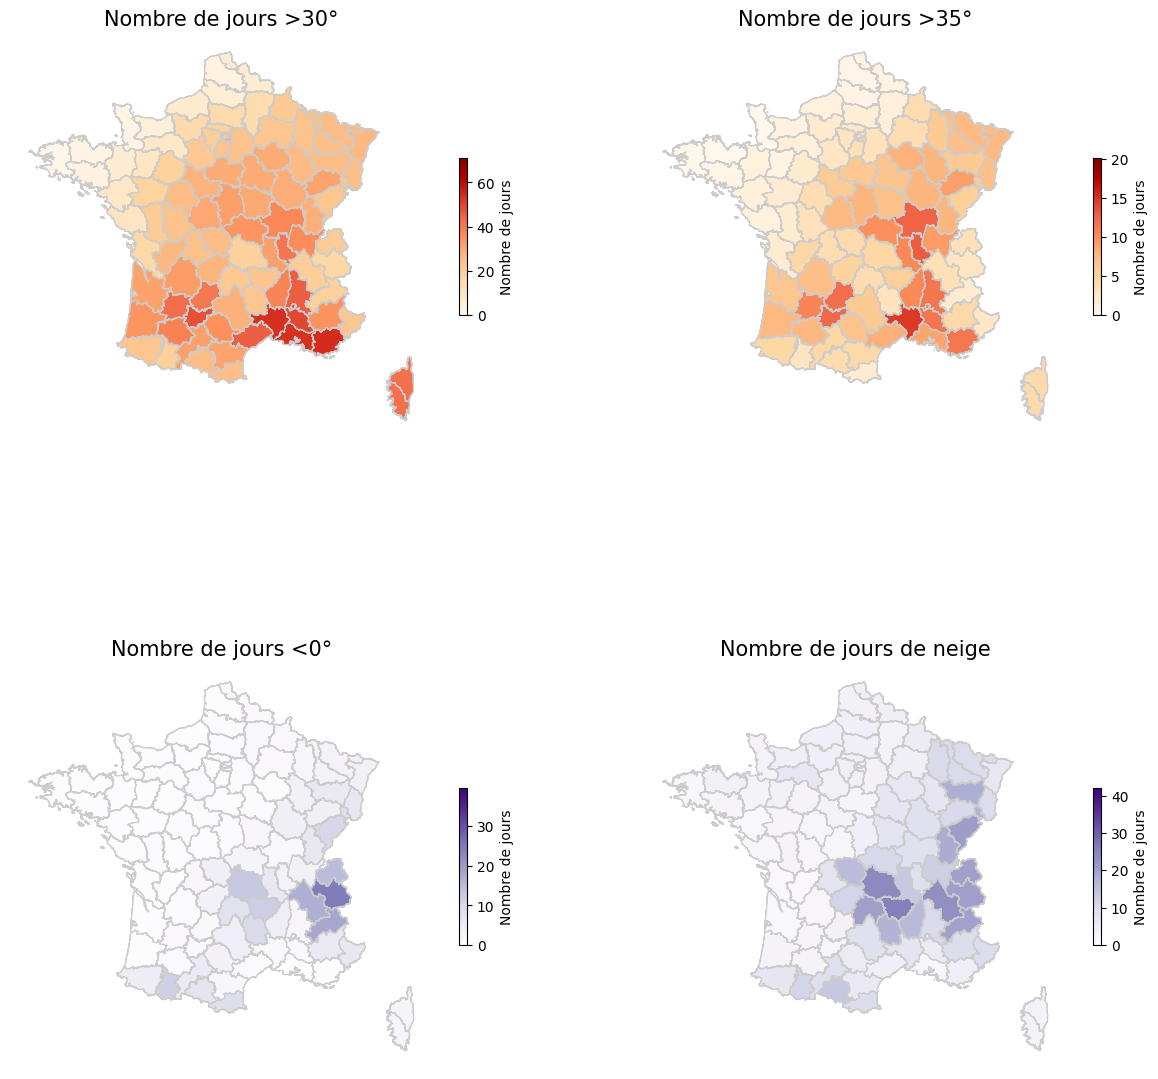

In [13]:
# TEMPS APPROXIMATIF : 40sec
# parametres
mois_ete = [6, 7, 8, 9]
mois_hiver = [1,2,3,12]
toutes_annees = [i for i in range(2011, 2020)]

from src.package_project import cartes, indicateurs_climat

# construction des cartes 

fig, ax = plt.subplots(2,2, figsize=(15, 15))

# été : nombre de jours à plus de 30 degrés et 35 degrés  
cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_par_an(df, toutes_annees, mois_ete, "NBJTX30")),
            toutes_annees,
            mois_ete,
            indicateur = "NBJTX30",
            titre_carte = "Nombre de jours >30°",
            titre_axe = "Nombre de jours",
            plotting = ax[0,0],
            evolution = False)

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_par_an(df, toutes_annees, mois_ete, "NBJTX35")),
            toutes_annees,
            mois_ete,
            "NBJTX35",
            "Nombre de jours >35°",
            titre_axe = "Nombre de jours",
            plotting = ax[0,1],
            evolution = False)

# # hiver : nombre de jours à moins de 0° ou de neige  

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_par_an(df, toutes_annees, mois_hiver, "NBJTX0")),
            toutes_annees,
            mois_hiver,
            "NBJTX0",
            "Nombre de jours <0°",
            titre_axe = "Nombre de jours",
            plotting = ax[1,0],
            evolution = False)

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_par_an(df, toutes_annees, mois_hiver, "NBJNEIG")),
            toutes_annees,
            mois_hiver,
            "NBJNEIG",
            "Nombre de jours de neige",
            titre_axe = "Nombre de jours",
            plotting = ax[1,1],
            evolution = False)



Nous observons que les zones les plus impactées par les fortes chaleur sont le littoral méditerranéen, les alentours du Rhone (à l'ouest de Lyon) et au milieu de la Garonne (départements du Tarn-et-Garonne et Lot-et-Garonne). Nous serons particulièrement attentifs aux évolutions du tourisme sur le littoral, étant donné qu'il s'agit d'une zone fortement touristique.

Les zones les plus froides se situent dans les Alpes. Avec le Massif Central, ce sont aussi celles les plus concernées par l'enneignement. 

Intéressons-nous à l'évolution de ces conditions climatiques au cours de la décennie 2010.

#### 2.1.2. Evolution dans le temps <a id="section_2_1_2"></a>

On s'intéresse maintenant à l'évolution du climat dans le temps. 

In [46]:
from src.package_project.Carte_dyn import gif
from IPython.display import display, HTML

gif("hiver")
gif("été")

html = """
<div style="display:flex;">
    <img src="cart_pour_les hiver.gif" style="width:500px;"/>
    <img src="cart_pour_les été.gif" style="width:500px;"/>
</div>
"""

display(HTML(html))

In [47]:
t1 = time.perf_counter()
print(f"Temps d'affichage : {t1 - t0:.3f}s")

Temps d'affichage : 77.323s


Ces cartes dynamiques nous permettent de constater que s'il y a une tendance au réchauffement entre 2011 et 2022 (en particulier l'été), il y a une certaine variabilité selon les années. 

Intéressons nous aux évènements extrèmes (forte chaleur ou températures basses). Pour lisser les variations annuelles, on s'intéresse à l'évolution de la moyenne du nombre annuel de jours extremes, entre avant 2015 (inclus) et après 2015 (non inclus.)

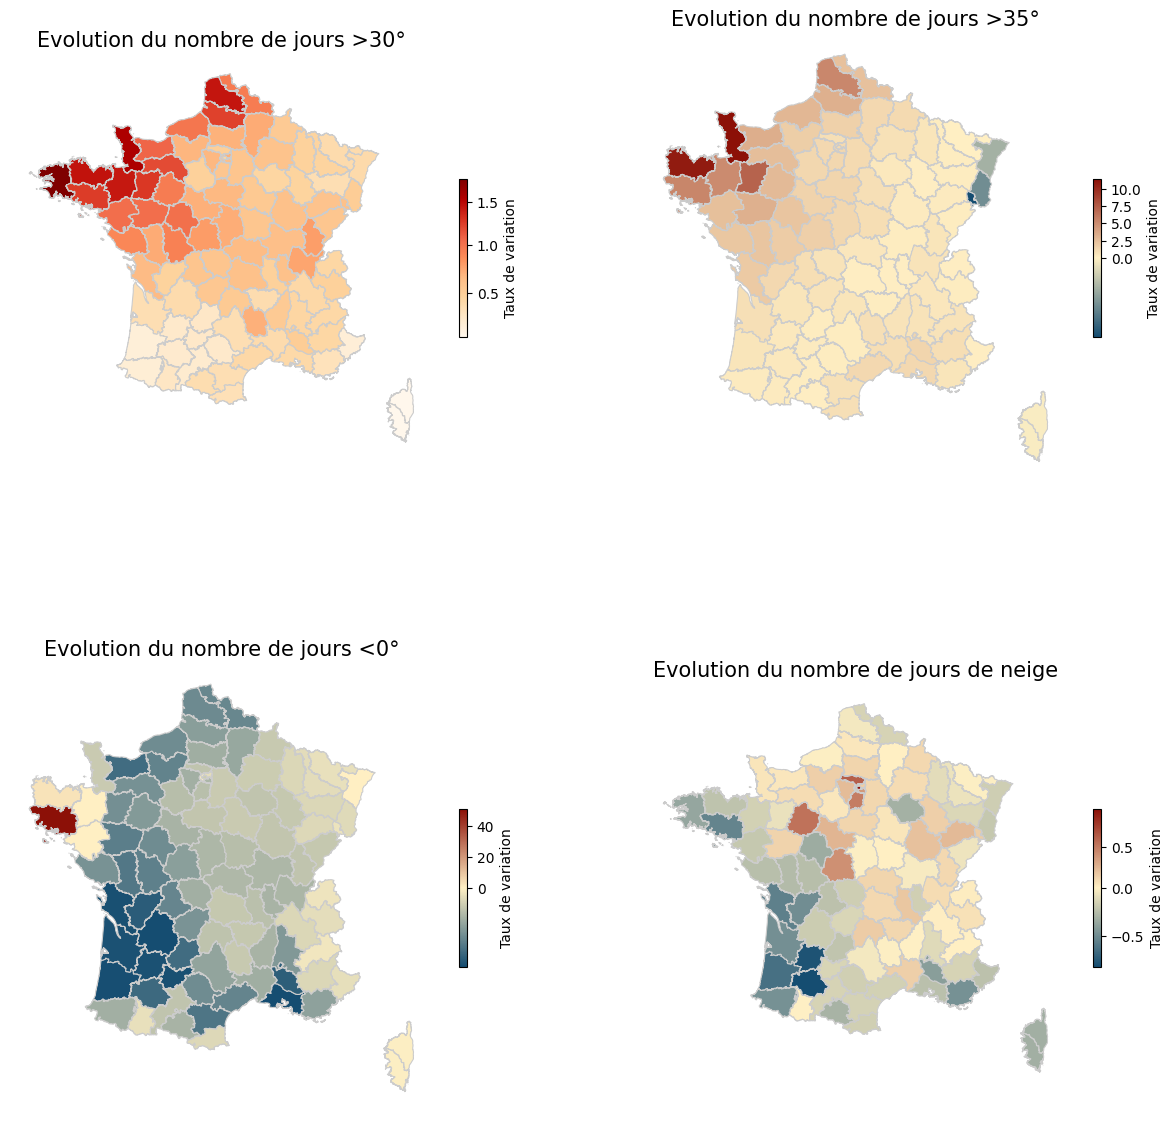

In [48]:
# évolution des évènements extremes 

fig, ax = plt.subplots(2,2, figsize=(15, 15))

# été : nombre de jours à plus de 30 degrés et 35 degrés  

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_evol_2015(df, "été", "NBJTX30")),
            toutes_annees,
            mois_ete,
            "NBJTX30",
            "Evolution du nombre de jours >30°",
            titre_axe = "Taux de variation",
            plotting = ax[0,0],
            evolution = True)

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_evol_2015(df, "été", "NBJTX35")),
            toutes_annees,
            mois_ete,
            "NBJTX35",
            "Evolution du nombre de jours >35°",
            titre_axe = "Taux de variation",
            plotting = ax[0,1],
            evolution = True)

# # hiver : nombre de jours à moins de 0° ou de neige  

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_evol_2015(df, "hiver", "NBJTX0")),
            toutes_annees,
            mois_hiver,
            "NBJTX0",
            "Evolution du nombre de jours <0°",
            titre_axe = "Taux de variation",
            plotting = ax[1,0],
            evolution = True)

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_climat.nbj_evol_2015(df, "hiver", "NBJNEIG")),
            toutes_annees,
            mois_hiver,
            "NBJNEIG",
            "Evolution du nombre de jours de neige",
            titre_axe = "Taux de variation",
            plotting = ax[1,1],
            evolution = True)

On observe d'abord que le nombre de jours annuels moyens de plus de 30° a augmenté entre avant 2015 et après 2015 sur l'ensemble du territoire. Une zone se démarque largement (la Bretagne), en raison de la faiblesse du nombre de jours chauds à l'origine dans cette zone comme le montrent les cartes précédentes. 

Le constat est relativement similaire pour les jours à plus de 35°, excepté pour les zones du Haut-Rhin et du Bas-Rhin caractérisées par une diminution de ces fortes chaleurs. 

Les zones littorales Atlantique (sous la Bretagne) et méditerrannée voient ces épisodes augmenter mais de manière similaire au reste du territoire. 

Le nombre annuel moyen de jours à moins de 0 degrés a diminué entre avant et après 2015 sur presque tout le territoire, excepté à nouveau en Bretagne. La tendance est moins claire pour les jours de neige, notamment sur les zones montagneuses.

### 2.2. Statistiques sur le tourisme <a id="section_2_2"></a>

#### 2.2.1. Répartition du tourisme sur le territoire <a id="section_2_2_1"></a>

Intéressons-nous à la répartition du tourisme sur le territoire français. Les cartes suivantes présentes la répartition du total des arrivées entre 2011 et 2019, en été et en hiver.

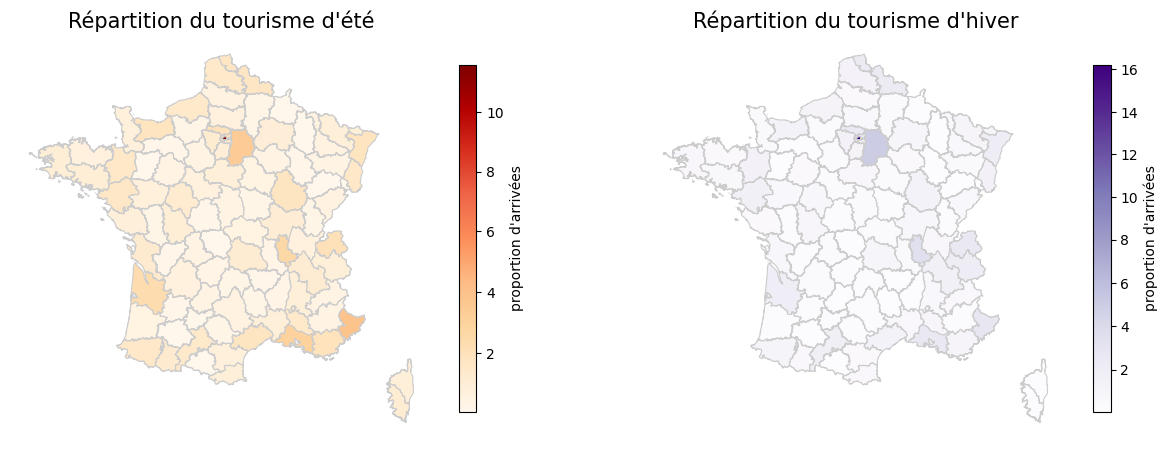

In [49]:
from src.package_project import indicateurs_tourisme

fig, ax = plt.subplots(1,2, figsize=(15, 15))

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_tourisme.repartition_arrivees(df, toutes_annees, mois_ete, ["DEP"])),
            toutes_annees,
            mois_ete,
            "part_tourisme",
            "Répartition du tourisme d'été",
            titre_axe = "proportion d'arrivées",
            plotting = ax[0],
            evolution = False)

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_tourisme.repartition_arrivees(df, toutes_annees, mois_hiver, ["DEP"])),
            toutes_annees,
            mois_hiver,
            "part_tourisme",
            "Répartition du tourisme d'hiver",
            titre_axe = "proportion d'arrivées",
            plotting = ax[1],
            evolution = False)



Alors que l'on pouvait s'attendre à une répartition peu équilibrée surle territoire, on observe une relative stabilité excepté sur le département parisien : la capitale absorbe une grande part du tourisme d'été ou d'hiver. Pour avoir une meilleure visibilité du tourisme littoral et montagneux, on exclut la région parisienne. 

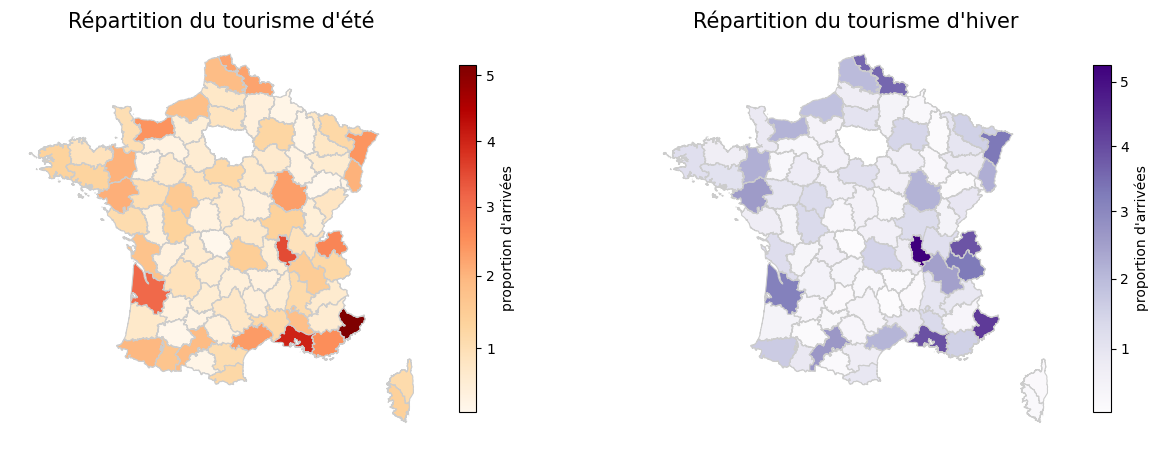

In [50]:
fig, ax = plt.subplots(1,2, figsize=(15, 15))

df_hors_idf = df.loc[~df["DEP"].isin(["75", "77", "78", "91", "92", "93", "94", "95"])]

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_tourisme.repartition_arrivees(df_hors_idf, toutes_annees, mois_ete, ["DEP"])),
            toutes_annees,
            mois_ete,
            "part_tourisme",
            "Répartition du tourisme d'été",
            titre_axe = "proportion d'arrivées",
            plotting = ax[0],
            evolution = False)

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_tourisme.repartition_arrivees(df_hors_idf, toutes_annees, mois_hiver, ["DEP"])),
            toutes_annees,
            mois_hiver,
            "part_tourisme",
            "Répartition du tourisme d'hiver",
            titre_axe = "proportion d'arrivées",
            plotting = ax[1],
            evolution = False)

Que ce soit pour l'été ou l'hiver, la répartition du tourisme (hors Ile-de-France) est inégalement répartie sur le territoire. Les zones littorales et montagneuses accueillent davantage de touristes que le centre de la France. 

La comparaison du tourisme d'été et d'hiver met en évidence un tourisme plus important sur le littoral l'été que l'hiver. 

Il est intéressant néanmoins de noter que la répartition reste proche entre l'été et l'hiver, malgré des conditions climatiques différentes. Une hypothèse pouvant l'expliquer est le fait qu'une partie du tourisme serait en réalité des déplacements non-touristiques (fréquentation d'un hôtel pour raison professionnelle par exemple). Dans ce cas, la répartition touristique est fortement influencée par l'activité économique des départements.

Si cette hypothèse est vérifiée, il est probable que les données donnent une corrélation assez faible entre fréquentation touristique et évolution du climat, a minima sur les départements non côtiers ou montagneux.

#### 2.2.2. Evolution des fréquentations touristiques <a id="section_2_2_2"></a>


On s'intéresse maintenant à l'évolution des fréquentations touristiques entre 2011 et 2019.

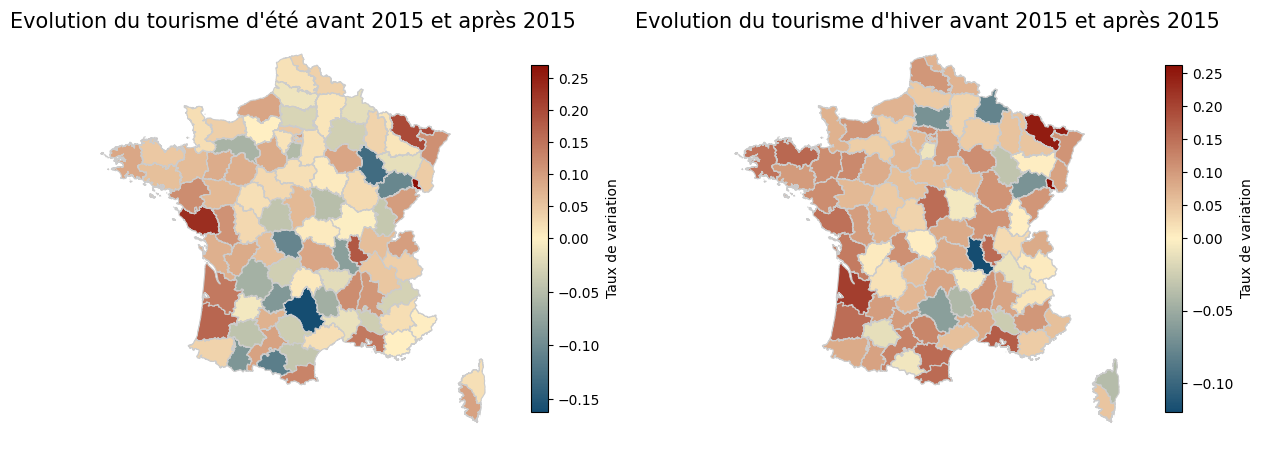

In [19]:
fig, ax = plt.subplots(1,2, figsize=(15, 15))

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_tourisme.evol_arrivees(df, mois_ete)),
            toutes_annees,
            mois_ete,
            "evol_2015",
            "Evolution du tourisme d'été avant 2015 et après 2015",
            "Taux de variation",
            ax[0],
            evolution = True)

cartes.mise_en_forme_carte(
            cartes.donnee_carte(indicateurs_tourisme.evol_arrivees(df, mois_hiver)),
            toutes_annees,
            mois_hiver,
            "evol_2015",
            "Evolution du tourisme d'hiver avant 2015 et après 2015",
            "Taux de variation",
            ax[1],
            evolution = True)

Ces deux cartes présentent le taux de variation du nombre annuel moyen d'arrivées touristiques par département, entre avant 2015 et après 2015. 

### 2.3. Corrélations <a id="section_2_3"></a>

#### 2.3.1. Corrélation climat - nombre d'arrivées (tous touristes confondus) <a id="section_2_3_1"></a>

Nous allons calculer le coefficient de corrélation global avant de s'intéresser aux coefficients de corrélation par département et par saison.

In [53]:
col_arrivees = "OBS_VALUE_CORR"
col_temp = "TX"

base_clean = df.dropna(subset=[col_arrivees, col_temp]).copy()

corr_global = base_clean[col_arrivees].corr(base_clean[col_temp], method="pearson")
print("Corrélation globale arrivées / TX :", corr_global)

Corrélation globale arrivées / TX : 0.1342470460568634


Nous calculons le coefficient de corrélation linéaire de Pearson entre le nombre d'arrivée touristiques (OBS_VALUE_CORR) et la température maximale moyenne mensuelle (TX) sur l'ensemble des départements et des périodes. 
Le coefficient de corrélation globale est 0.13, ce qui traduit un lien positif mais faible entre les deux variables : les hausses de températures s'accompagnent en moyenne d'une légère hausse des arrivées, sans que le climat ne soit le déterminant principal des flux. 

Nous qualifions de forte une corrélation lorsque |r|≥0.5 et nous affichons uniquement les départements présentant une corrélation fortement positive (r≥0.5) ou fortement négative (r≤−0,5).

In [54]:
# Par Département
corr_par_dep = (
    base_clean
    .groupby("DEP")[[col_arrivees, col_temp]] 
    .apply(lambda g: g[col_arrivees].corr(g[col_temp], method="pearson"))
    .reset_index(name="corr_arrivees_TX")
)

dep_corr_forte_pos = corr_par_dep[corr_par_dep["corr_arrivees_TX"] >= 0.75]
liste_dep_forte_positive = corr_par_dep.loc[corr_par_dep["corr_arrivees_TX"] >= 0.75, "DEP"].tolist()
dep_corr_forte_neg = corr_par_dep[corr_par_dep["corr_arrivees_TX"] <= -0.5]

print("Départements à corrélation fortement POSITIVE :")
print(dep_corr_forte_pos)
print(liste_dep_forte_positive)

print("\nDépartements à corrélation fortement NÉGATIVE :")
print(dep_corr_forte_neg)

Départements à corrélation fortement POSITIVE :
   DEP  corr_arrivees_TX
0   01          0.838250
1   02          0.894587
2   03          0.898257
3   04          0.919176
5   06          0.949000
..  ..               ...
86  86          0.777954
87  87          0.895722
89  89          0.954886
90  90          0.750479
95  95          0.783724

[79 rows x 2 columns]
['01', '02', '03', '04', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '21', '22', '23', '24', '25', '26', '27', '28', '29', '2A', '2B', '30', '31', '32', '33', '34', '35', '36', '37', '39', '40', '41', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '54', '55', '56', '57', '58', '60', '61', '62', '63', '64', '65', '66', '68', '70', '71', '72', '76', '79', '80', '81', '82', '83', '84', '85', '86', '87', '89', '90', '95']

Départements à corrélation fortement NÉGATIVE :
Empty DataFrame
Columns: [DEP, corr_arrivees_TX]
Index: []


In [55]:
# Par Département
corr_par_dep = (
    base_clean
    .groupby("DEP")[[col_arrivees, col_temp]] 
    .apply(lambda g: g[col_arrivees].corr(g[col_temp], method="pearson"))
    .reset_index(name="corr_arrivees_TX")
)

dep_corr_forte_pos = corr_par_dep[corr_par_dep["corr_arrivees_TX"] >= 0.75]
liste_dep_forte_positive = corr_par_dep.loc[corr_par_dep["corr_arrivees_TX"] >= 0.75, "DEP"].tolist()
dep_corr_forte_neg = corr_par_dep[corr_par_dep["corr_arrivees_TX"] <= -0.5]

print("Départements à corrélation fortement POSITIVE :")
print(dep_corr_forte_pos)
print(liste_dep_forte_positive)

print("\nDépartements à corrélation fortement NÉGATIVE :")
print(dep_corr_forte_neg)



Départements à corrélation fortement POSITIVE :
   DEP  corr_arrivees_TX
0   01          0.838250
1   02          0.894587
2   03          0.898257
3   04          0.919176
5   06          0.949000
..  ..               ...
86  86          0.777954
87  87          0.895722
89  89          0.954886
90  90          0.750479
95  95          0.783724

[79 rows x 2 columns]
['01', '02', '03', '04', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '21', '22', '23', '24', '25', '26', '27', '28', '29', '2A', '2B', '30', '31', '32', '33', '34', '35', '36', '37', '39', '40', '41', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '54', '55', '56', '57', '58', '60', '61', '62', '63', '64', '65', '66', '68', '70', '71', '72', '76', '79', '80', '81', '82', '83', '84', '85', '86', '87', '89', '90', '95']

Départements à corrélation fortement NÉGATIVE :
Empty DataFrame
Columns: [DEP, corr_arrivees_TX]
Index: []


In [56]:
# Par Saison
corr_par_saison = (
    base_clean
    .groupby("saison")[[col_arrivees, col_temp]] 
    .apply(lambda g: g[col_arrivees].corr(g[col_temp], method="pearson"))
    .reset_index(name="corr_arrivees_TX")
)

print("\nCorrélation arrivées / TX par saison :")
print(corr_par_saison)

# Par Période
corr_par_periode = (
    base_clean
    .groupby("periode")[[col_arrivees, col_temp]] 
    .apply(lambda g: g[col_arrivees].corr(g[col_temp], method="pearson"))
    .reset_index(name="corr_arrivees_TX")
)

print("\nCorrélation arrivées / TX par période :")
print(corr_par_periode)


Corrélation arrivées / TX par saison :
  saison  corr_arrivees_TX
0  Other          0.070795
1  hiver          0.015581
2    été          0.052825

Corrélation arrivées / TX par période :
      periode  corr_arrivees_TX
0  apres_2015          0.129323
1  avant_2015          0.137920


TypeError: mise_en_forme_carte() got an unexpected keyword argument 'titre_axe'. Did you mean 'titre_carte'?

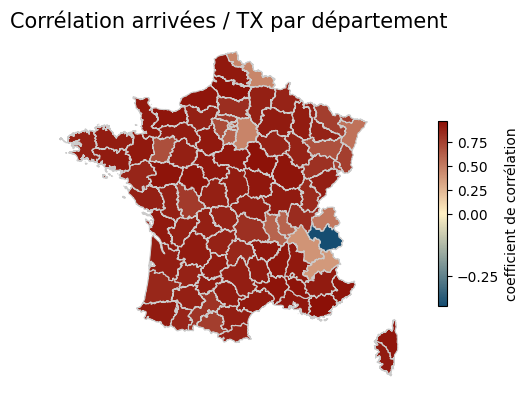

In [57]:
corr_dep = corr_par_dep.copy()
corr_dep["DEP"] = corr_dep["DEP"].astype(str).str.zfill(2)

annees = toutes_annees
mois=mois_ete
fig, ax = plt.subplots(figsize=(6, 8))

cartes.mise_en_forme_carte(
    cartes.donnee_carte(corr_dep),
    annees=toutes_annees,
    mois=mois_ete,
    indicateur= "corr_arrivees_TX", 
    titre_carte= "Corrélation arrivées / TX par département", 
    titre_axe = "coefficient de corrélation",
    plotting=ax, 
    evolution=False
)



Toutefois, cet indicateur reste limité : il repose sur les températures de l’année N, alors que les touristes choisissent en général leur destination plusieurs mois à l’avance, en se basant plutôt sur les conditions observées des années précédentes.
Dans cette optique, nous construisons deux nouveaux indicateurs climatiques : un indice de chaleur en N-1 et un indice de froid en N-1, afin d’analyser plus précisément la corrélation entre le climat de l'année N-1 et les arrivées de touristes en année N.

Nous allons créer un nouvel indicateur reliant les arrivées touristiques de l’année N à un indice de chaleur estivale décalé d’un an (N−1), afin d’intégrer l’idée que les décisions de voyage peuvent dépendre des conditions climatiques observées l’année précédente. 

Tout d'abord, nous allons construire l’indice de chaleur annuel (seulement mois d'été) par département et l’indice de froid annuel (seulement mois d'hiver) par département.

In [58]:
import pandas as pd

# On part de df = base climat + tourisme fusionnée
df_ind = df.copy()

# Mois d'été et d'hiver
mois_ete = [6, 7, 8, 9]
mois_hiver = [12, 1, 2, 3]

# On choisit de garder d'un côté les mois été, de l'autre les mois hiver
df_ete = df_ind[df_ind["MM"].isin(mois_ete)].copy()
df_hiver = df_ind[df_ind["MM"].isin(mois_hiver)].copy()

# Indice de chaleur mensuel (pondération des jours très chauds)
df_ete["indice_chaleur_mensuel"] = (
    df_ete["NBJTX25"].fillna(0)
    + df_ete["NBJTX30"].fillna(0)
    + 2 * df_ete["NBJTX35"].fillna(0)
)

# Indice de froid mensuel (pondération des jours avec de la neige et avec un sol enneigé)
df_hiver["indice_froid_mensuel"] = (
    df_hiver["NBJTX0"].fillna(0)
    + 2 * df_hiver["NBJNEIG"].fillna(0)
    + 2 * df_hiver["NBJSOLNG"].fillna(0)
)

# Agrégation annuelle par département :
# - somme des arrivées
# - somme de l'indice de chaleur sur les mois d'été
base_ind = (
    df_ete
    .groupby(["DEP", "AAAA",], as_index=False)
    .agg(
        arrivees=("OBS_VALUE_CORR", "sum"),
        indice_chaleur=("indice_chaleur_mensuel", "sum")
    )
)

# Agrégation annuelle par département :
# - somme des arrivées
# - somme de l'indice de froid sur les mois d'hiver
base_ind_froid = (
    df_hiver
    .groupby(["DEP", "AAAA"], as_index=False)
    .agg(
        arrivees=("OBS_VALUE_CORR", "sum"),
        indice_froid=("indice_froid_mensuel", "sum")
    )
)

base_ind.head()

,DEP,AAAA,arrivees,indice_chaleur
0,01,2011,288060.0,72.750000
1,01,2012,310260.0,80.375000
2,01,2013,325860.0,81.559289
3,01,2014,337270.0,62.249012
4,01,2015,319150.0,121.833333


In [ ]:
base_ind_froid.head()

,DEP,AAAA,arrivees,indice_froid
0,01,2011,208170.0,35.278856
1,01,2012,212430.0,78.594697
2,01,2013,236480.0,52.239380
3,01,2014,240960.0,42.116330
4,01,2015,247160.0,29.405212


Dans base_ind, la colonne arrivees = somme des arrivées d’été (mois 6–9).

Dans base_ind_froid, la colonne arrivees = somme des arrivées d’hiver (mois 12–3).

Maintenant, nous allons construire l'indicateur chaleur pour l'année N-1, c'est à dire décaler d'une année celui créer précédemment.

In [59]:
# On s'assure que les lignes sont bien triées
base_ind = base_ind.sort_values(["DEP", "AAAA"])

# Pour chaque département, on décale l'indice de chaleur d'une année
base_ind["indice_chaleur_N_1"] = (
    base_ind
    .groupby("DEP")["indice_chaleur"]
    .shift(1)     # année précédente
)

# On enlève les années où on n'a pas encore de N-1 (première année de chaque DEP)
base_lag = base_ind.dropna(subset=["indice_chaleur_N_1"]).copy()

base_lag.head()

,DEP,AAAA,arrivees,indice_chaleur,indice_chaleur_N_1
1,01,2012,310260.0,80.375000,72.750000
2,01,2013,325860.0,81.559289,80.375000
3,01,2014,337270.0,62.249012,81.559289
4,01,2015,319150.0,121.833333,62.249012
5,01,2016,330540.0,101.875000,121.833333


Nous allons faire de même pour l'indice froid.

In [ ]:
base_ind_froid = base_ind_froid.sort_values(["DEP", "AAAA"])

base_ind_froid["indice_froid_N_1"] = (
    base_ind_froid
    .groupby("DEP")["indice_froid"]
    .shift(1)      # année précédente
)

base_lag_froid = base_ind_froid.dropna(subset=["indice_froid_N_1"]).copy()

base_lag_froid.head()

,DEP,AAAA,arrivees,indice_froid,indice_froid_N_1
1,01,2012,212430.0,78.594697,35.278856
2,01,2013,236480.0,52.239380,78.594697
3,01,2014,240960.0,42.116330,52.239380
4,01,2015,247160.0,29.405212,42.116330
5,01,2016,230810.0,34.427800,29.405212


Nous allons maintenant calculer la corrélation globale arrivées N vs indice chaleur N-1.

In [60]:
corr_global_lag = base_lag["arrivees"].corr(
    base_lag["indice_chaleur_N_1"],
    method="pearson"
)

print("Corrélation globale arrivées (année N) / indice de chaleur (année N-1) :",
      corr_global_lag)

Corrélation globale arrivées (année N) / indice de chaleur (année N-1) : 0.014789098747197874


Nous avons construit un indicateur de « chaleur estivale » en année N–1, défini comme une combinaison pondérée du nombre de jours avec des températures maximales supérieures à 25 °C, 30 °C et 35 °C, agrégé par département et par année. Nous avons ensuite calculé la corrélation entre cet indice de chaleur en année N–1 et le nombre d’arrivées touristiques en année N.

Le coefficient de corrélation obtenu est très faible et légèrement négatif (ρ ≈ –0,007).
Le signe est cohérent, en théorie, avec l’idée qu’un excès de chaleur pourrait freiner les arrivées touristiques, mais la magnitude est tellement faible qu’on ne peut pas parler de relation robuste : l’indicateur de chaleur de l’été N-1 n’explique quasiment rien des variations d’arrivées en année N au niveau départemental.

Ce résultat suggère que, dans nos données, les variations interannuelles des arrivées touristiques sont surtout déterminées par d’autres facteurs (conjoncture économique, coût du transport, effets exceptionnels comme la crise Covid, etc.), et que le niveau de chaleur de l’été précédent ne permet pas, à lui seul, d’expliquer les variations des flux touristiques départementaux.

Nous allons maintenant calculer la corrélation globale arrivées N vs indice froid N-1.

In [ ]:
corr_global_lag_froid = base_lag_froid["arrivees"].corr(
    base_lag_froid["indice_froid_N_1"],
    method="pearson"
)

print("Corrélation globale arrivées (année N) / indice de froid (année N-1) :",
      corr_global_lag_froid)

Corrélation globale arrivées (année N) / indice de froid (année N-1) : -0.012817768954158293


Nous construisons un indice de « froid hivernal » en année N-1, puis nous mesurons sa corrélation avec les arrivées touristiques en année N. Le coefficient obtenu est très faible et légèrement négatif (ρ ≈ –0,013).
Une valeur aussi proche de zéro indique qu’il n’existe pratiquement aucune relation linéaire entre la sévérité du froid de l’hiver précédent et le volume d’arrivées touristiques observées l’année suivante, au niveau départemental.
Le signe négatif va dans le sens intuitif d’un possible effet dissuasif d’hivers rigoureux, mais la magnitude de la corrélation est beaucoup trop faible pour être considérée comme significative : l’indice de froid N-1 ne permet pas, à lui seul, d’expliquer les variations des flux touristiques.

Nous aimerions réaliser une carte afin d'observer le coefficient de corrélation par département entre l'indice chaleur l'année N-1 et le nombre d'arrivée l'année N.

In [ ]:
# Par département pour indice chaleur

corr_par_dep_lag = (
    base_lag
    .groupby("DEP")
    .apply(lambda g: g["arrivees"].corr(g["indice_chaleur_N_1"], method="pearson"))
    .reset_index(name="corr_arrivees_indice_N_1")
)

corr_par_dep_lag.head()

dep_corr_forte_positive = corr_par_dep_lag[corr_par_dep_lag["corr_arrivees_indice_N_1"] >= 0.75]
liste_dep_forte_negative= corr_par_dep_lag.loc[corr_par_dep_lag["corr_arrivees_indice_N_1"] <= -0.5, "DEP"].tolist()
dep_corr_forte_negative = corr_par_dep_lag[corr_par_dep_lag["corr_arrivees_indice_N_1"] <= -0.5]

print("Départements à corrélation fortement POSITIVE :")
print(dep_corr_forte_positive)

print("\nDépartements à corrélation fortement NÉGATIVE :")
print(dep_corr_forte_negative)
print(liste_dep_forte_negative)


Départements à corrélation fortement POSITIVE :
   DEP  corr_arrivees_indice_N_1
12  13                  0.771936
15  16                  0.795958
33  33                  0.757993
34  34                  0.821703
49  49                  0.858882
69  69                  0.772462
76  76                  0.752251

Départements à corrélation fortement NÉGATIVE :
   DEP  corr_arrivees_indice_N_1
39  39                 -0.640643
48  48                 -0.727872
52  52                 -0.624248
58  58                 -0.514156
65  65                 -0.631469
70  70                 -0.844077
80  80                 -0.673708
91  91                 -0.565718
['39', '48', '52', '58', '65', '70', '80', '91']


Nous aimerions réaliser une carte afin d'observer le coefficient de corrélation par département entre l'indice froid l'année N-1 et le nombre d'arrivée l'année N.

In [ ]:
# Par département pour indice froid 

corr_par_dep_lag_froid = (
    base_lag_froid
    .groupby("DEP")
    .apply(lambda g: g["arrivees"].corr(g["indice_froid_N_1"], method="pearson"))
    .reset_index(name="corr_froid_arrivees_indice_N_1")
)

corr_par_dep_lag_froid.head()

dep_corr_froid_forte_positive = corr_par_dep_lag_froid[corr_par_dep_lag_froid["corr_froid_arrivees_indice_N_1"] >= 0.75]
liste_froid_dep_forte_negative= corr_par_dep_lag_froid.loc[corr_par_dep_lag_froid["corr_froid_arrivees_indice_N_1"] <= -0.5, "DEP"].tolist()
dep_corr_froid_forte_negative = corr_par_dep_lag_froid[corr_par_dep_lag_froid["corr_froid_arrivees_indice_N_1"] <= -0.5]

print("Départements à corrélation fortement POSITIVE - indice froid :")
print(dep_corr_froid_forte_positive)

print("\nDépartements à corrélation fortement NÉGATIVE - indice froid:")
print(dep_corr_froid_forte_negative)
print(liste_froid_dep_forte_negative)

Départements à corrélation fortement POSITIVE - indice froid :
Empty DataFrame
Columns: [DEP, corr_froid_arrivees_indice_N_1]
Index: []

Départements à corrélation fortement NÉGATIVE - indice froid:
Empty DataFrame
Columns: [DEP, corr_froid_arrivees_indice_N_1]
Index: []
[]


Nous allons donc réaliser la carte permettant de représenter les coefficients de corrélation par département en considérant l'indice chaleur.

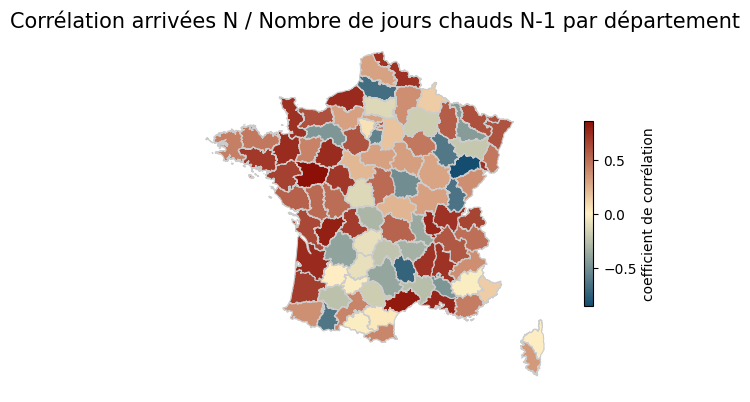

In [ ]:
corr_dep2 = corr_par_dep_lag.copy()
corr_dep2["DEP"] = corr_dep2["DEP"].astype(str).str.zfill(2)

annees = toutes_annees
mois=mois_ete
fig, ax = plt.subplots(figsize=(6, 8))

cartes.mise_en_forme_carte(
    cartes.donnee_carte(corr_dep2),
    annees=toutes_annees,
    mois=mois_ete,
    indicateur= "corr_arrivees_indice_N_1", 
    titre_carte= "Corrélation arrivées N / Nombre de jours chauds N-1 par département", 
    titre_axe = "coefficient de corrélation",
    plotting=ax, 
    evolution=False
)

La légende utilise une échelle centrée sur 0 :

- en bleu, les corrélations négatives (dans ces départements, les années précédées d’un été plus chaud tendent plutôt à être associées à des niveaux d’arrivées légèrement plus faibles) ;
- en rouge, les corrélations positives (les années précédées d’un été plus chaud sont associées à des arrivées un peu plus élevées) ;
- les tons beige / gris clair correspondants à des corrélations proches de 0, c’est-à-dire pas de lien linéaire marqué.

La carte met en évidence des corrélations plutôt négatives dans une grande partie du centre de la France métropolitaine : dans ces départements, les années où l’été précédent a été plus chaud sont légèrement associées à une baisse des arrivées touristiques.

À l’inverse, les corrélations sont moins négatives, voire légèrement positives, dans certains départements littoraux, dans les zones de montagne proches des Alpes et en Corse.

Globalement, les coefficients restent de faible amplitude, ce qui suggère que, même si la chaleur estivale peut jouer un rôle localement, les flux touristiques d’été ne semblent pas fortement pilotés par le nombre de jours très chauds de l’année N-1, surtout à cette échelle départementale.

Nous allons maintenant réaliser la carte permettant de représenter les coefficients de corrélation par département en considérant l'indice froid.

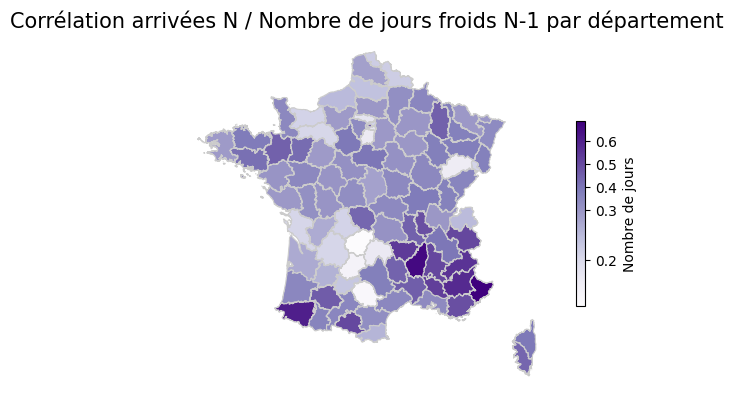

In [ ]:
corr_dep3 = corr_par_dep_lag_froid.copy()
corr_dep3["DEP"] = corr_dep3["DEP"].astype(str).str.zfill(2)

annees = toutes_annees
mois=mois_hiver
fig, ax = plt.subplots(figsize=(6, 8))

cartes.mise_en_forme_carte(
    cartes.donnee_carte(corr_dep3),
    annees=toutes_annees,
    mois=mois_hiver,
    indicateur= "corr_froid_arrivees_indice_N_1", 
    titre_carte= "Corrélation arrivées N / Nombre de jours froids N-1 par département", 
    plotting=ax, 
    evolution=False
)

#### 2.3.2. Corrélation climat - nombre d'arrivées selon l'origine des touristes <a id="section_2_3_1"></a>

Nous trouvons que c'est également intéressant de prendre en compte l'origine des touristes dans nos indices de corrélation. Tout d'abord, nous voulons observer la part des touristes internationaux dans le total des arrivées. 

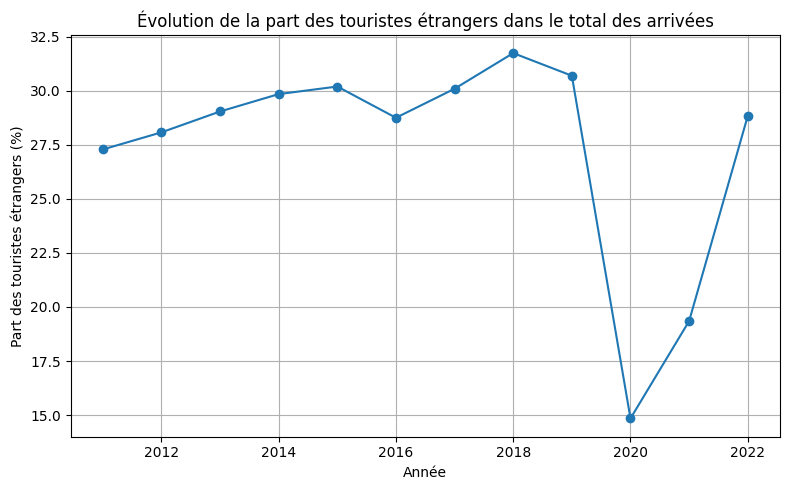

In [ ]:
tour = data_3.copy()

# 1. On agrège par année et origine du touriste
agg = (
    tour
    .groupby(["AAAA", "TOUR_RESID"], as_index=False)["OBS_VALUE_CORR"]
    .sum()
)

# 2. On met France / Étranger en colonnes
pivot = agg.pivot(index="AAAA", columns="TOUR_RESID", values="OBS_VALUE_CORR")

# Sécuriser les noms de colonnes (accents ou pas selon ta base)
pivot = pivot.rename(columns={
    "Étranger": "etranger",
    "France": "france"
})

# 3. Part des étrangers dans le total par année
pivot["part_etrangers"] = pivot["etranger"] / (pivot["etranger"] + pivot["france"])

# 4. Tracé de la courbe
plt.figure(figsize=(8, 5))
plt.plot(pivot.index, 100 * pivot["part_etrangers"], marker="o")
plt.xlabel("Année")
plt.ylabel("Part des touristes étrangers (%)")
plt.title("Évolution de la part des touristes étrangers dans le total des arrivées")
plt.grid(True)
plt.tight_layout()
plt.show()

Nous observons que la part des touristes internationaux en France métropolitaine varie entre 27% et 32% entre 2011 et 2019, avec une tendance globalement haussière, à l’exception de 2016 et 2019. 
Nous pouvons également observer l'effet du Covid19 sur les flux touristiques internationaux. En effet, une forte baisse est visible : les touristes internationaux représentent moins de 15% des arrivées. On observe ensuite un rebond, avec une part qui remonte à 19 % en 2021, puis 28,5 % en 2022.
Globalement, la part des touristes internationaux est donc orientée à la hausse, hors événements majeurs perturbant la mobilité internationale.

Dans la suite, nous cherchons à mesurer dans quelle mesure le réchauffement climatique influence les déplacements touristiques internationaux en France métropolitaine. Nous excluons, ainsi, les années 2020 et 2021, dont les flux sont fortement perturbés par la crise sanitaire et donc peu représentatifs de la dynamique climatique.

Nous avons remarqué que lorsque l'on prend l'origine des touristes en compte, les lignes se dédoublent. Ainsi pour ne pas impacter les programmes précédents, nous allons créer une nouvelle base de données en prenant en compte data_3 à la place de data_2. Nous suivons les mêmes étapes que celles vues dans la section précédente.

In [ ]:
# data_1 : climat (DEP, AAAA, MM, NBJTX25, NBJTX30, NBJ35, NBJTX0, NBJNEIG, NBJSOLNG, etc.)
# data_3 : tourisme avec origine (DEP, AAAA, MM, TOUR_RESID, OBS_VALUE_CORR, ...)

dl = data_1.merge(
    data_3,
    on=["DEP", "AAAA", "MM"],
    how="left")

In [ ]:
dl_ind = dl.copy()

# On enlève 2020 et 2021
dl_ind = dl_ind[~dl_ind["AAAA"].isin([2020, 2021])]

dl_ete = dl_ind[dl_ind["MM"].isin(mois_ete)].copy()
dl_hiver = dl_ind[dl_ind["MM"].isin(mois_hiver)].copy()

# Indice de chaleur mensuel
dl_ete["indice_chaleur_mensuel"] = (
    dl_ete["NBJTX25"].fillna(0)
    + dl_ete["NBJTX30"].fillna(0)
    + 2 * dl_ete["NBJTX35"].fillna(0)
)

# Indice de froid mensuel
dl_hiver["indice_froid_mensuel"] = (
    dl_hiver["NBJTX0"].fillna(0)
    + 2 * dl_hiver["NBJNEIG"].fillna(0)
    + 2 * dl_hiver["NBJSOLNG"].fillna(0)
)

# Été : agrégation annuelle par DEP, AAAA, origine
base_ind2 = (
    dl_ete
    .groupby(["DEP", "AAAA", "TOUR_RESID"], as_index=False)
    .agg(
        arrivees=("OBS_VALUE_CORR", "sum"),
        indice_chaleur=("indice_chaleur_mensuel", "sum")
    )
)

# Hiver : agrégation annuelle par DEP, AAAA, origine
base_ind_froid2 = (
    dl_hiver
    .groupby(["DEP", "AAAA", "TOUR_RESID"], as_index=False)
    .agg(
        arrivees=("OBS_VALUE_CORR", "sum"),
        indice_froid=("indice_froid_mensuel", "sum")
    )
)

base_ind2.head()

,DEP,AAAA,TOUR_RESID,arrivees,indice_chaleur
0,01,2011,France,204650.0,72.750000
1,01,2011,Étranger,83410.0,72.750000
2,01,2012,France,232450.0,80.375000
3,01,2012,Étranger,77810.0,80.375000
4,01,2013,France,242350.0,81.559289


In [ ]:
base_ind_froid2.head()

,DEP,AAAA,TOUR_RESID,arrivees,indice_froid
0,01,2011,France,169010.0,35.278856
1,01,2011,Étranger,39160.0,35.278856
2,01,2012,France,170660.0,78.594697
3,01,2012,Étranger,41800.0,78.594697
4,01,2013,France,188410.0,52.239380


In [ ]:
# On s'assure que c’est trié
base_ind2 = base_ind2.sort_values(["DEP", "TOUR_RESID", "AAAA"])

# Création de l'indice de chaleur de l'année N-1 par DEP + origine
base_ind2["indice_chaleur_N_1"] = (
    base_ind2
    .groupby(["DEP", "TOUR_RESID"])["indice_chaleur"]
    .shift(1)   # année précédente
)

# On enlève les lignes sans N-1 (première année de chaque série)
base_lag_chaleur2 = base_ind2.dropna(subset=["indice_chaleur_N_1"]).copy()

# On garde uniquement les Touristes internationaux 
etranger_chaleur2 = base_lag_chaleur2[base_lag_chaleur2["TOUR_RESID"] == "Étranger"].copy()

# Corrélation globale (tous départements, toutes années)
corr_etranger_chaleur_globale2 = etranger_chaleur2["arrivees"].corr(
    etranger_chaleur2["indice_chaleur_N_1"],
    method="pearson"
)

print("Corrélation globale (Touristes internationaux année N vs indice chaleur année N-1) :", corr_etranger_chaleur_globale2)

# si on regarde la corrélation globale pour les Français
# On garde uniquement les Français
français_chaleur2 = base_lag_chaleur2[base_lag_chaleur2["TOUR_RESID"] == "France"].copy()

# Corrélation globale
corr_français_chaleur_globale2 = français_chaleur2["arrivees"].corr(
    français_chaleur2["indice_chaleur_N_1"],
    method="pearson"
)

print("Corrélation globale (Touristes français année N vs indice chaleur année N-1) :", corr_français_chaleur_globale2)


# Corrélation par département
corr_etranger_chaleur_dep2 = (
    etranger_chaleur2
    .groupby("DEP")
    .apply(lambda g: g["arrivees"].corr(g["indice_chaleur_N_1"], method="pearson"))
    .reset_index(name="corr_arrivees_indice_chaleur_N_1")
)

print("\nCorrélation par département (Touristes internationaux  année N vs indice chaleur année N-1) :")
print(corr_etranger_chaleur_dep2)

Corrélation globale (Touristes internationaux année N vs indice chaleur année N-1) : -0.02335301663580819
Corrélation globale (Touristes français année N vs indice chaleur année N-1) : 0.05174374162071084

Corrélation par département (Touristes internationaux  année N vs indice chaleur année N-1) :
   DEP  corr_arrivees_indice_chaleur_N_1
0   01                          0.265553
1   02                         -0.091116
2   03                         -0.072594
3   04                         -0.373635
4   05                          0.600053
..  ..                               ...
91  91                         -0.439563
92  92                          0.567485
93  93                          0.436741
94  94                          0.085729
95  95                         -0.316909

[96 rows x 2 columns]


In [ ]:
# Tri
base_ind_froid2 = base_ind_froid2.sort_values(["DEP", "TOUR_RESID", "AAAA"])

# Indice de froid de l'année N-1
base_ind_froid2["indice_froid_N_1"] = (
    base_ind_froid2
    .groupby(["DEP", "TOUR_RESID"])["indice_froid"]
    .shift(1)
)

# On enlève les lignes sans N-1
base_lag_froid2 = base_ind_froid2.dropna(subset=["indice_froid_N_1"]).copy()

# On garde uniquement les Touristes internationaux 
etranger_froid = base_lag_froid2[base_lag_froid2["TOUR_RESID"] == "Étranger"].copy()

# Corrélation globale
corr_etranger_froid_globale = etranger_froid["arrivees"].corr(
    etranger_froid["indice_froid_N_1"],
    method="pearson"
)

print("Corrélation globale (Touristes internationaux année N vs indice froid année N-1) :", corr_etranger_froid_globale)

# si on regarde la corrélation globale pour les Français
# On garde uniquement les Français
francais_froid = base_lag_froid2[base_lag_froid2["TOUR_RESID"] == "France"].copy()

# Corrélation globale
corr_francais_froid_globale = francais_froid["arrivees"].corr(
    francais_froid["indice_froid_N_1"],
    method="pearson"
)

print("Corrélation globale (Touristes français année N vs indice froid année N-1) :", corr_francais_froid_globale)

# Corrélation par département
corr_etranger_froid_dep = (
    etranger_froid
    .groupby("DEP")
    .apply(lambda g: g["arrivees"].corr(g["indice_froid_N_1"], method="pearson"))
    .reset_index(name="corr_arrivees_indice_froid_N_1")
)

print("\nCorrélation par département (Touristes internationaux année N vs indice froid année N-1) :")
print(corr_etranger_froid_dep)



Corrélation globale (Touristes internationaux année N vs indice froid année N-1) : -0.03701130646808346
Corrélation globale (Touristes français année N vs indice froid année N-1) : -0.06870367536024577

Corrélation par département (Touristes internationaux année N vs indice froid année N-1) :
   DEP  corr_arrivees_indice_froid_N_1
0   01                        0.262705
1   02                       -0.127711
2   03                       -0.278934
3   04                       -0.211048
4   05                       -0.084610
..  ..                             ...
91  91                        0.261227
92  92                        0.220519
93  93                        0.252988
94  94                        0.054285
95  95                        0.164717

[96 rows x 2 columns]


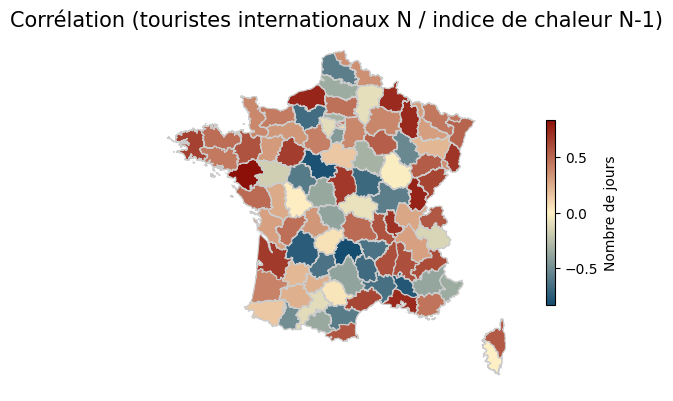

In [ ]:
# Copie + formatage du code département
corr_etranger_chaleur_map = corr_etranger_chaleur_dep2.copy()
corr_etranger_chaleur_map["DEP"] = (
    corr_etranger_chaleur_map["DEP"]
    .astype(str)
    .str.zfill(2)
)

fig, ax = plt.subplots(figsize=(6, 8))

cartes.mise_en_forme_carte(
    cartes.donnee_carte(corr_etranger_chaleur_map),
    annees=toutes_annees,
    mois=mois_ete,   # été, puisque c’est l’indice de chaleur
    indicateur="corr_arrivees_indice_chaleur_N_1",
    titre_carte="Corrélation (touristes internationaux N / indice de chaleur N-1)",
    plotting=ax,
    evolution=False
)

plt.show()

Sur cette carte, on se concentre sur les touristes internationaux et le lien entre leurs arrivées en année N et notre indice de chaleur de l’été N-1. On voit que plusieurs départements littoraux ou déjà très touristiques (Ouest, Sud-Ouest, une partie du Nord) ont des corrélations plutôt positives : après un été plus chaud, les arrivées étrangères ont tendance à augmenter l’année suivante, ce qui suggère que la chaleur reste plutôt attractive dans ces zones “soleil/mer”. À l’inverse, quelques départements plus intérieurs ou montagneux ressortent en négatif, ce qui laisse penser que des étés très chauds peuvent y devenir un facteur de désaffection. Au final, l’effet de la chaleur de l’été précédent est localisé et hétérogène : il dépend beaucoup du type de territoire, et ne suffit clairement pas, à lui seul, à expliquer les flux de touristes internationaux.

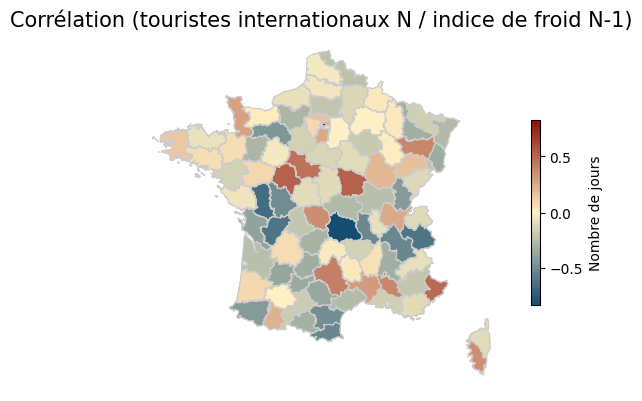

In [ ]:
# Copie + formatage du code département
corr_etranger_froid_map = corr_etranger_froid_dep.copy()
corr_etranger_froid_map["DEP"] = (
    corr_etranger_froid_map["DEP"]
    .astype(str)
    .str.zfill(2)
)

fig, ax = plt.subplots(figsize=(6, 8))

cartes.mise_en_forme_carte(
    cartes.donnee_carte(corr_etranger_froid_map),
    annees=toutes_annees,
    mois=mois_hiver,   # hiver, pour l’indice de froid
    indicateur="corr_arrivees_indice_froid_N_1",
    titre_carte="Corrélation (touristes internationaux N / indice de froid N-1)",
    plotting=ax,
    evolution=False
)

plt.show()

Sur cette carte, on regarde cette fois les touristes internationaux et l’indice de froid de l’hiver N-1 (jours ≤ 0°C, neige, sol enneigé). Globalement, le signal est assez dispersé : on trouve quelques corrélations positives dans certains territoires de montagne ou de l’intérieur (où des hivers plus « neigeux » peuvent favoriser les séjours au ski), mais aussi des corrélations négatives dans d’autres départements, y compris parfois voisins. Il n’y a pas de grand bloc cohérent qui ressort (ni franchement positif, ni franchement négatif) à l’échelle de la France métropolitaine. En pratique, cela suggère que, pour les touristes internationaux, la sévérité de l’hiver précédent joue un rôle très local et probablement secondaire dans leurs choix de destination, comparé à d’autres facteurs (accessibilité, image de la station, prix, etc.).

## 3. Modélisation <a id="chapter_3"></a>
### 3.1. Présentation du modèle <a id="section_3_1"></a>

#### Cadre théorique : désaisonnalisation <a id="section_3_1_1"></a>

Pourquoi désaisonnaliser avant les tests de stationnarité ? 

Les tests de racine unitaire (ADF, PP, KPSS) reposent sur des hypothèses asymptotiques qui sont violées en présence de : saisonnalité déterministe non traitée, ruptures périodiques régulières (mensuelles ici). 

Une saisonnalité non corrigée peut conduire à : une fausse non-stationnarité, une surestimation de l’ordre d’intégration, des conclusions erronées sur la cointégration.

Approche retenue : saisonnalité déterministe Nous utilisons une approche classique et valide économétriquement :

Yt = µ + 𝛿1 * D1 + ... + 𝛿12 * D11 + ε où ε~BB(0,sd), 𝐷𝑚 : sont des dummies mensuelles, 

Décision : si au moins un coefficient saisonnier est significatif alors saisonnalité présente sinon alors pas de correction nécessaire

#### Cadre théorique : test de Dickey-Fuller augmenté (ADF)<a id="section_3_1_2"></a>

Problématique de la stationnarité En économétrie des séries temporelles, une série non stationnaire pose trois problèmes majeurs : risque de régression fallacieuse(significativité de certaines correlations qui ne sont pas coherents), lois asymptotiques non standards, tests de significativité invalides.

Une série est stationnaire si : sa moyenne est constante, sa variance est finie et constante, sa structure d’autocorrélation est stable dans le temps

H₀ : la série possède une racine unitaire (non stationnaire) VS H₁ : la série est stationnaire

Décision : si p-value < α → rejet de H₀ → série stationnaire sinon on calcule la serie differncier(Yt - Yt-1) puis on refait le test.

l'ordre d'integration est le nombre de foi que l'on à du differencier la serie pour que celle -ci devienne stattionnaire

#### Cadre théorique :modèle ARDL<a id="section_3_1_3"></a>

Le modèle ARDL (AutoRegressive Distributed Lag) est adapté lorsque : 

Les variables sont intégrées d’ordre différent (I(0) et I(1)), et que l'on souhaite distinguer effets de court terme et relation de long terme de certaine variables exogènes( dans notre cas ce sont les variables qui caracterisent le climet).

Forme générale :

Yt = µ + 𝛿1 * D1 + ... + 𝛿12 * D11 + a1 * Yt-1 + ... + ap * Yt-p + b1 * X't + ... + bq * X't-p + ε ou ε~BB(0,sd)

Yt: flux touristique à la periode t

𝑋t : variables climatiques à la periode t

𝛽 : effet du climat sur le flux touristique

#### Modèle de prediction :XGBOOST<a id="section_3_1_4"></a>

XGBoost est un algorithme de gradient boosting sur arbres de décision qui construit un modèle prédictif comme une somme séquentielle d’arbres faibles, chaque nouvel arbre corrigeant les erreurs des précédents par descente de gradient. 

Sa spécificité réside dans une fonction objectif régularisée et l’utilisation d’une approximation de Taylor d’ordre 2, ce qui lui confère une forte performance prédictive, au prix d’une interprétabilité limitée et sans vocation causale.

### 3.2. Application de la methodologie sur le Departement d'Allier <a id="section_3_2"></a>


DÉPARTEMENT : Allier

#1) Préparation des données
DÉPARTEMENT 03
2011 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2012 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2013 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2014 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2015 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2016 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2017 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2018 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2019 : mois observés → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

NOTE MÉTHODOLOGIQUE
- Données postérieures à 2020 exclues (crise sanitaire)
- Mois manquants interpolés par méthode temporelle
- Flux touristique transformé en logarithme

#2) Analyse de la saisonnalité et de la stationnarité

------------------------------
VARIABLE : OBS_VALUE_CORR
------------------------------


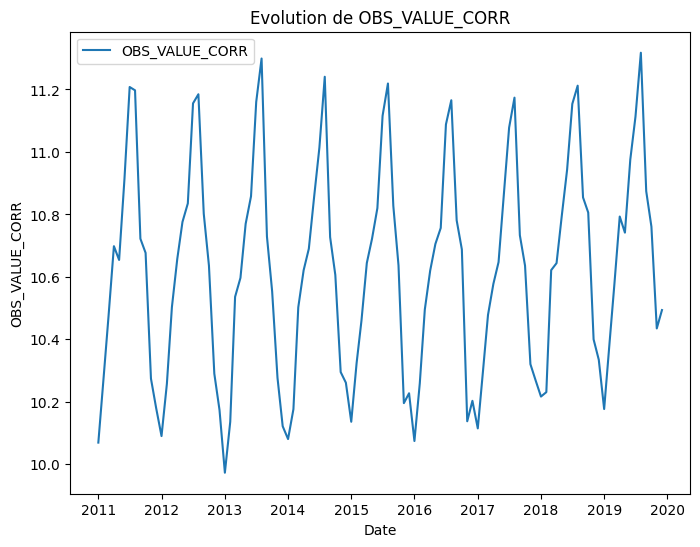

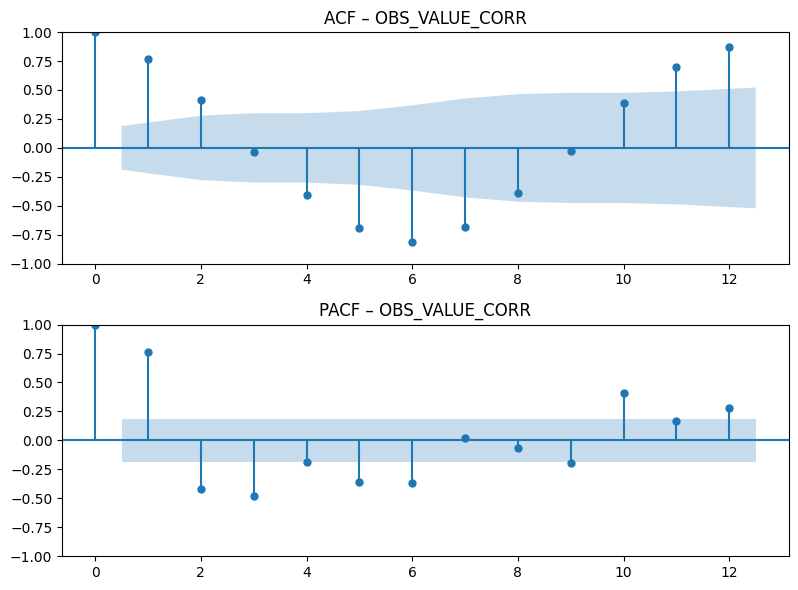

TEST DE SAISONNALITÉ DÉTERMINISTE
                            OLS Regression Results                            
Dep. Variable:         OBS_VALUE_CORR   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     257.0
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           4.79e-66
Time:                        18:54:40   Log-Likelihood:                 138.57
No. Observations:                 108   AIC:                            -253.1
Df Residuals:                      96   BIC:                            -221.0
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept 

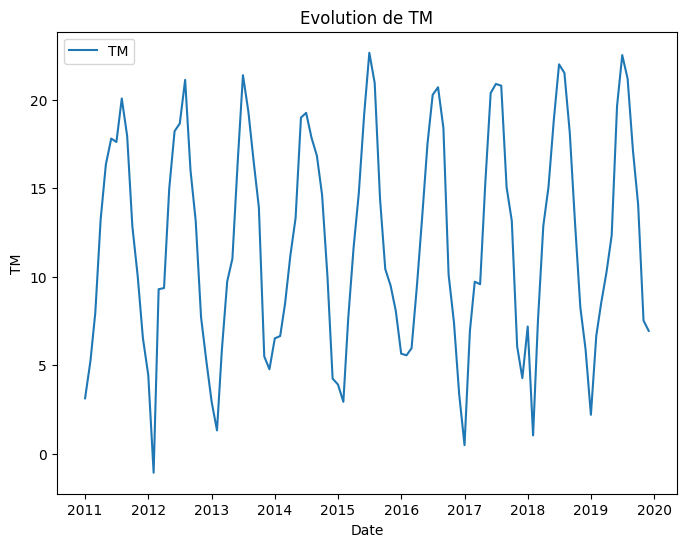

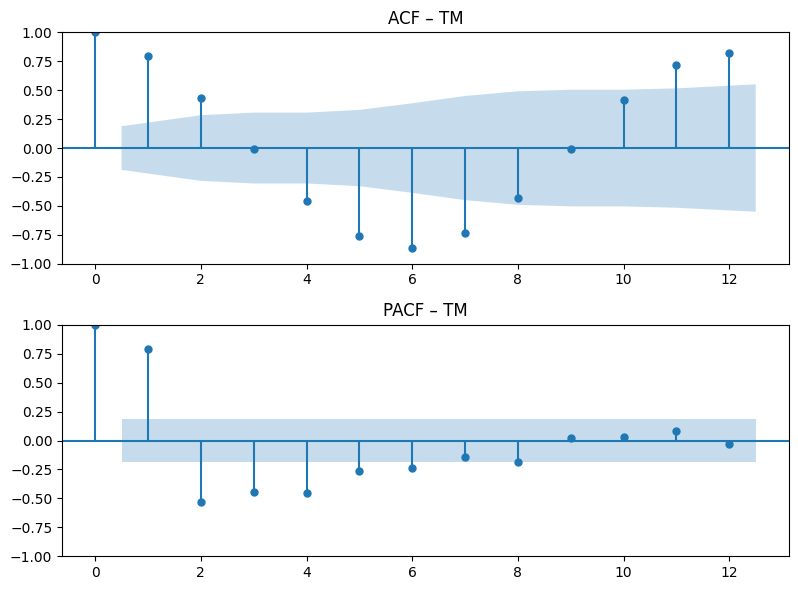

TEST DE SAISONNALITÉ DÉTERMINISTE
                            OLS Regression Results                            
Dep. Variable:                     TM   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     136.6
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           1.58e-53
Time:                        18:54:40   Log-Likelihood:                -204.85
No. Observations:                 108   AIC:                             433.7
Df Residuals:                      96   BIC:                             465.9
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept 

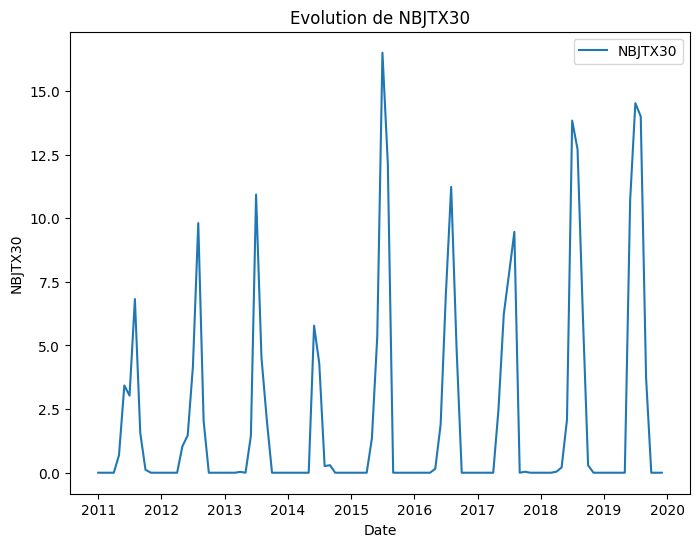

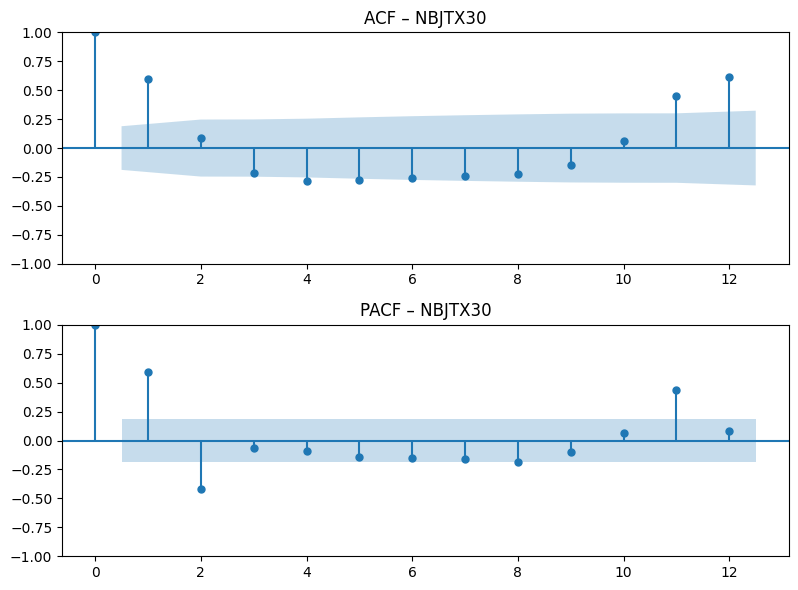

TEST DE SAISONNALITÉ DÉTERMINISTE
                            OLS Regression Results                            
Dep. Variable:                NBJTX30   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     14.92
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           4.85e-13
Time:                        18:54:40   Log-Likelihood:                -233.39
No. Observations:                 108   AIC:                             490.8
Df Residuals:                      96   BIC:                             523.0
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept 

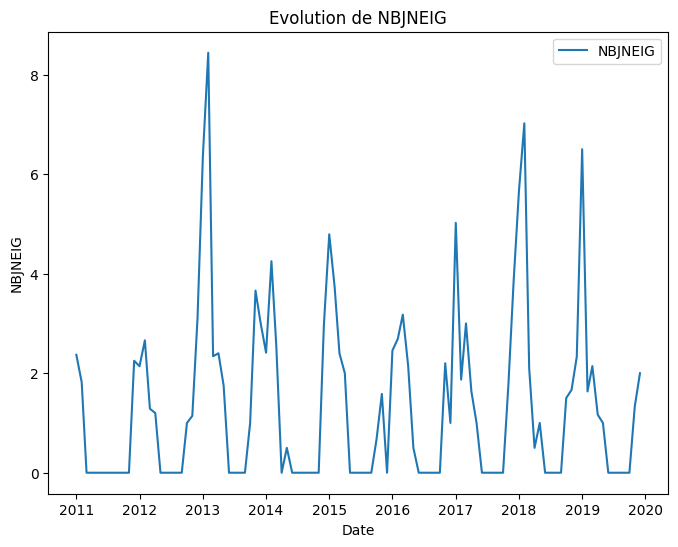

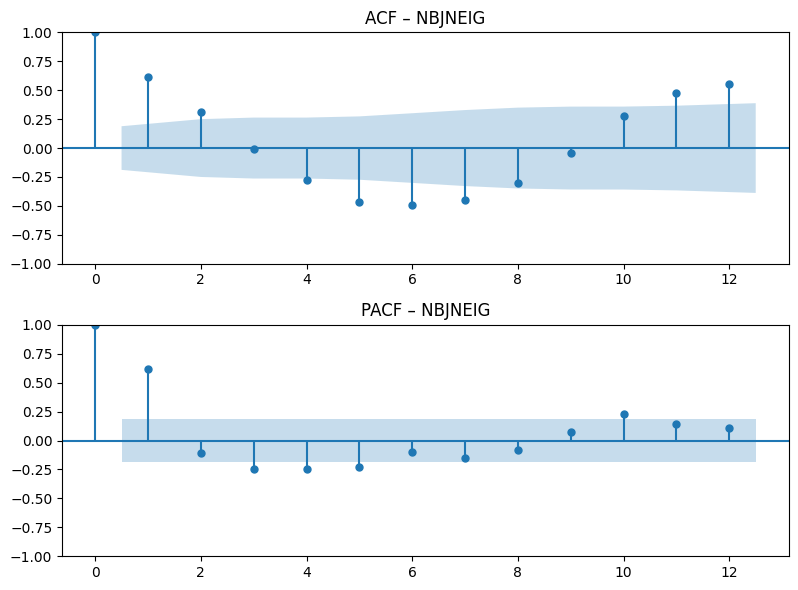

TEST DE SAISONNALITÉ DÉTERMINISTE
                            OLS Regression Results                            
Dep. Variable:                NBJNEIG   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     24.32
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           5.26e-20
Time:                        18:54:41   Log-Likelihood:                -156.38
No. Observations:                 108   AIC:                             336.8
Df Residuals:                      96   BIC:                             368.9
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept 

Modèle retenu : ARDL(2,0)
Résultats de l’estimation ARDL
                                ARDL Model Results                                
Dep. Variable:             OBS_VALUE_CORR   No. Observations:                  108
Model:             Seas. ARDL(2, 0, 0, 0)   Log Likelihood                 157.599
Method:                   Conditional MLE   S.D. of innovations              0.055
Date:                    Sun, 28 Dec 2025   AIC                           -279.199
Time:                            18:54:44   BIC                           -231.257
Sample:                        03-01-2011   HQIC                          -259.768
                             - 12-01-2019                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.4623      1.268      1.942      0.055      -0.057       4.982
s(2,12)              

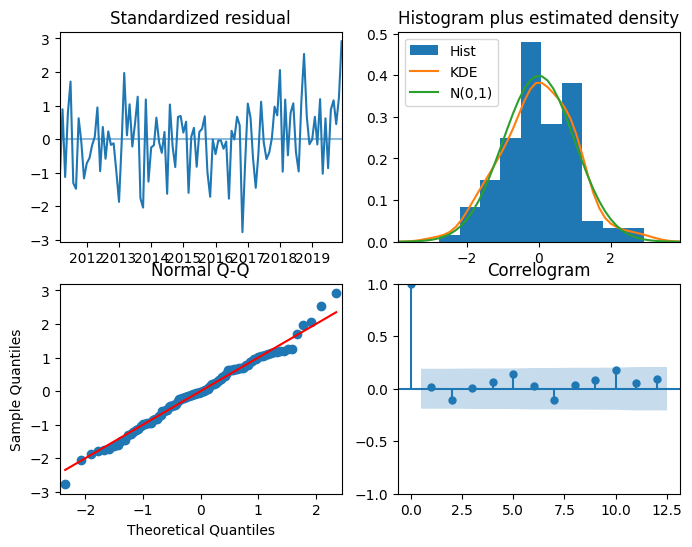

Rélation de long terme Analyse
                                UECM Model Results                                
Dep. Variable:           D.OBS_VALUE_CORR   No. Observations:                  108
Model:             Seas. UECM(2, 1, 1, 1)   Log Likelihood                 157.169
Method:                   Conditional MLE   S.D. of innovations             10.634
Date:                    Sun, 28 Dec 2025   AIC                           -278.338
Time:                            18:54:45   BIC                           -230.396
Sample:                        03-01-2011   HQIC                          -258.907
                             - 12-01-2019                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.8200      1.167      2.416      0.018       0.500       5.140
s(2,12)                 0.1925      0.034

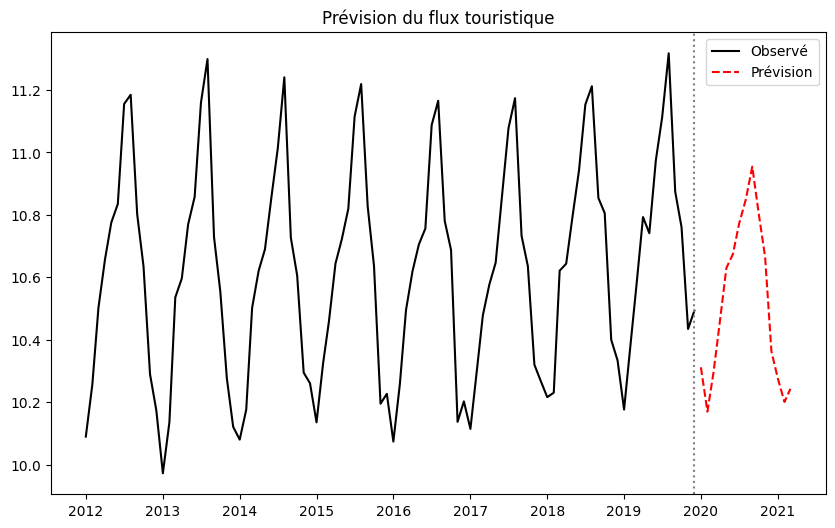

(3,
 'Allier',
 {2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2012: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2013: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2014: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2015: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2016: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2017: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2018: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
  2019: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]},
 np.int64(0),
 ('Série corrigée de la saisonnalité déterministe', 1),
 ('Série corrigée de la saisonnalité déterministe', 0),
 ('Série corrigée de la saisonnalité déterministe', 0),
 ('Série corrigée de la saisonnalité déterministe', 0),
 'Il existe une relation de long terme entre le climat et les flux touristiques. Le changement climatique influence structurellement l’attractivité touristique.',
 'bon')

In [64]:
from src.package_project.Test import Test, Resultat
Test(3)

In [ ]:
#cette cellule prend plus de 10 minutes 
t0 = time.perf_counter()
dataset = Resultat(95)
clear_output(wait=True)
t1 = time.perf_counter()
print(f"Temps d'execution : {t1 - t0:.3f}s")

Temps d'execution : 625.057s


In [ ]:
import pandas as pd
dataset.to_csv("dataset.csv")
dataset.head()

,departement,nom_dep,donne_pres,qualite,OBS_VALUE_CORR,TM,NBJTX30,NBJNEIG,conclusion,code
0,1.0,Ain,"{2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]...",0.0,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,Il existe une relation de long terme entre le ...,bon
1,2.0,Aisne,"{2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]...",0.0,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,Les résultats sont ambigus. La relation de lon...,incertain
2,3.0,Allier,"{2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]...",0.0,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,Il existe une relation de long terme entre le ...,bon
3,4.0,Alpes-de-Haute-Provence,"{2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]...",0.0,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,Les variables climatiques ne présentent pas d’...,mauvais
4,5.0,Hautes-Alpes,"{2011: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]...",0.0,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,(Série corrigée de la saisonnalité déterminist...,Il existe une relation de long terme entre le ...,bon


In [ ]:
dataset.code.value_counts()

code
mauvais      58
bon          30
incertain     3
Name: count, dtype: int64

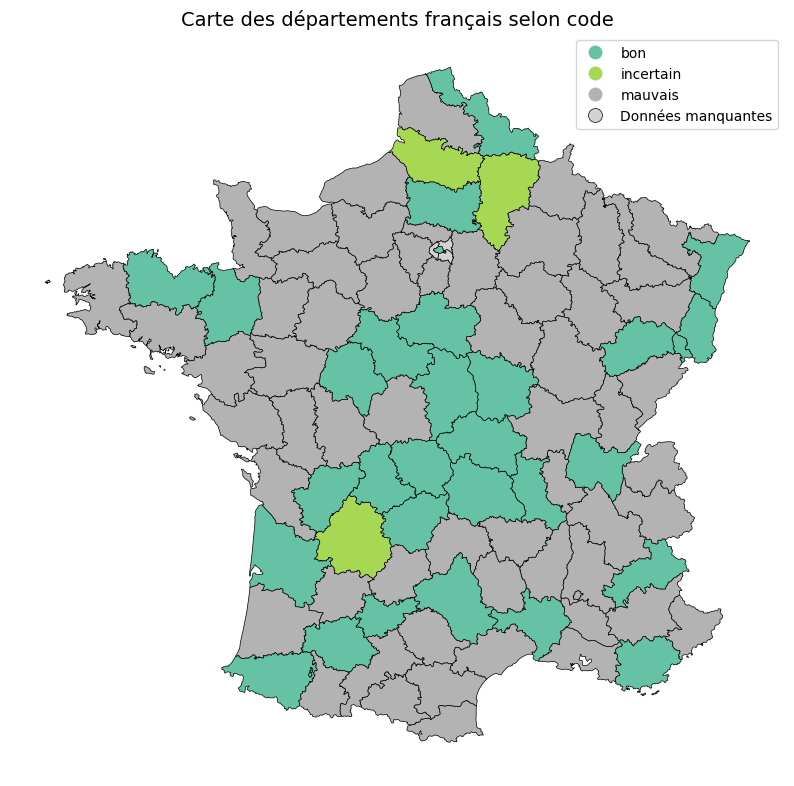

In [ ]:
dataset = pd.read_csv("dataset.csv")
from src.package_project.Carte_dyn import carte_departements
carte_departements(dataset)